# Grab the data from NPM

Let's do this in a dedicated step and then save the result, so we don't spam NPM with requests while we play with the graph plotting.

In [ ]:
import requests
import pandas as pd

package_name = 'prettier'
start_year = 2016
end_year = 2024

local_file_path = f'/content/npm_download_{package_name}_{start_year}_{end_year}_data.csv'

all_data = pd.DataFrame()

for year in range(start_year, end_year + 1):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    url = f"https://api.npmjs.org/downloads/range/{start_date}:{end_date}/{package_name}"

    # Make the request
    response = requests.get(url)
    if response.status_code == 200:
        # Load data into a DataFrame
        data = response.json()['downloads']
        df = pd.DataFrame(data)
        df['day'] = pd.to_datetime(df['day'])  # Convert to datetime
        all_data = pd.concat([all_data, df], ignore_index=True)
    else:
        print(f"Failed to retrieve data for {year}: {response.status_code}")
        continue

all_data.to_csv(local_file_path, index=False)
print(f"Data saved to '{local_file_path}'")



Data saved to '/content/npm_download_prettier_2016_2024_data.csv'


# Noramlize the data and plot

This will:

* Aggregate daily data into weekly totals
* Plot the data.
* Additionally, plot a smoothed equivalent.

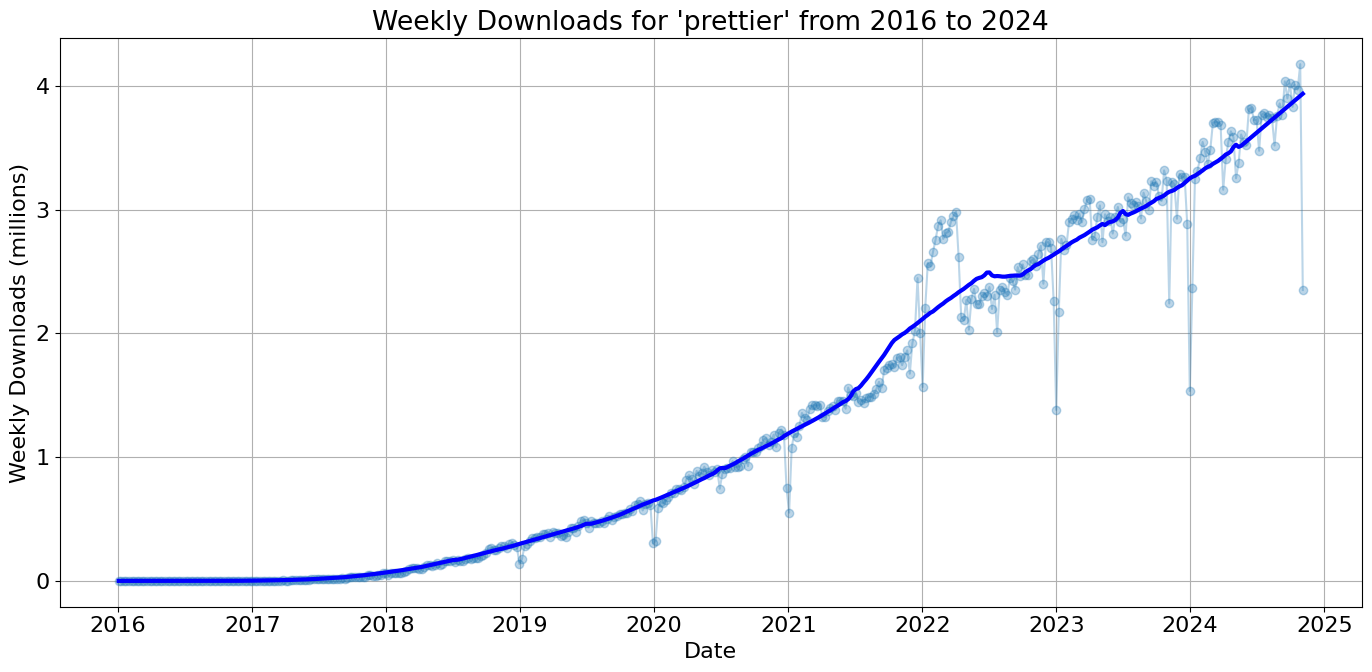

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from scipy.ndimage import gaussian_filter1d

all_data = pd.read_csv(local_file_path)
all_data['day'] = pd.to_datetime(all_data['day'])

# Aggregate daily data into weekly totals
all_data.set_index('day', inplace=True)
weekly_data = all_data.resample('W').sum()  # Resample by week

# Increase fontsize for all labels.
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(14, 7))
plt.plot(weekly_data.index, weekly_data['downloads'], marker='o', linestyle='-', alpha=0.3, label="Original (with outliers)")

# # Apply Savitzky-Golay Filter
savgol = savgol_filter(weekly_data['downloads'], window_length=50, polyorder=1)
plt.plot(weekly_data.index, savgol, linewidth=3, label="Savitzky-Golay (degree 2)", color='blue')

# Remove the scientific notation offset... we have 'millions' in the axis label.
plt.gca().yaxis.get_offset_text().set_visible(False)

plt.xlabel("Date")
plt.ylabel("Weekly Downloads (millions)")
plt.title(f"Weekly Downloads for '{package_name}' from {start_year} to {end_year}")
plt.grid(True)
plt.tight_layout()
plt.show()